# DGV-PT1
Notebook per la previsione di `time1` su griglia variabile.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/input/DGV_PT1_train.csv")
test_df = pd.read_csv("data/input/DGV_PT1_test.csv")
all_df = pd.concat([train_df, test_df])

## Regressione lineare
Il primo modello da considerare è la regressione lineare.

In [2]:
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
data = CosmoData(train_df, None, test_df)
reg = reg.fit(data.train_set()[0], data.train_set()[1])

test_res_lr = test_df.copy()
test_res_lr["target"] = test_res_lr.time1
test_res_lr["prediction"] = np.exp(reg.predict(data.test_set()[0]))
test_res_lr["residual"] = test_res_lr.target - test_res_lr.prediction
test_res_lr["abs_err"] = (test_res_lr.target - test_res_lr.prediction).abs()
test_res_lr["rel_err"] = test_res_lr.abs_err / test_res_lr.target
test_res_lr[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,12.482856,0.366950
std,26.210029,0.309915
min,0.010423,0.000914
25%,1.487115,0.128839
50%,4.091390,0.289918
75%,10.256269,0.516962
max,274.201838,1.421216


In [3]:
print("RMSE:", np.sqrt((test_res_lr.abs_err ** 2).mean()))

RMSE: 29.01896514078914


Il grafico del tempo previsto e del tempo osservato mostra come la regressione lineare sottostimi i tempi più lunghi e come tale errore aumenti all'aumentare del tempo osservato.

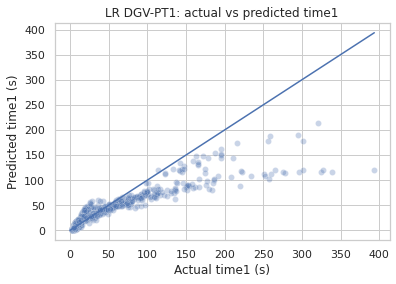

In [4]:
plt.title("LR DGV-PT1: actual vs predicted time1")
plt.plot([0, test_res_lr.time1.max()], [0, test_res_lr.time1.max()])
sns.scatterplot(data=test_res_lr, x="time1", y="prediction", alpha=0.3)
plt.xlabel("Actual time1 (s)")
plt.ylabel("Predicted time1 (s)")
plt.savefig("tex/images/dgv-pt1/lr-correlazione-osservazione-previsione.pdf")
plt.show()

Possiamo notare la medesima cosa analizzando il grafico dei residui. Inoltre possiamo notare come si presente un pattern che suggerisce non linearità: il grafico del confronto tra previsione e residuo dovrebbe avere un aspetto casuale, proprio perché l'errore della previsione dovrebbe essere casuale.

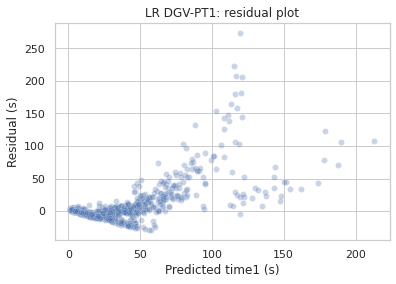

In [5]:
plt.title("LR DGV-PT1: residual plot")
sns.scatterplot(data=test_res_lr, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time1 (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgv-pt1/lr-grafico-residui.pdf")
plt.show()

## DGV-PT1 senza HP tuning

La prima prova con un FCNN viene fatta usando due hidden layer, addestrata per 500 epoch.

In [6]:
config = {
    "batch": "full",
    "optimizer": {
        "name": "adam",
        "lr": 0.05,
        "weight_decay": 0.0
    },
    "loss": "mse",
    "model": {
        "layers": [{
            "size": 14,
            "dropout": 0.0,
        }, {
            "size": 7,
            "dropout": 0.0
        }]
    }
}
data = CosmoData(train_df, None, test_df, config["batch"])
model = CosmoPredictor(data.input_size, config)
train_res_noopt = model.fit(data, 500)
test_res_noopt = model.test(data)

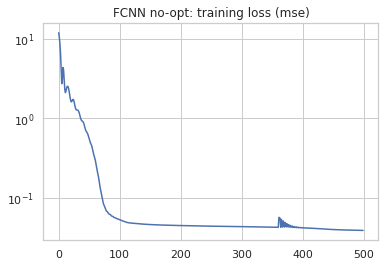

In [7]:
train_res_noopt.train_loss.plot(grid=True, logy=True)
plt.title(f"FCNN no-opt: training loss ({config['loss']})")
plt.show()

Si può notare un miglioramento rispetto al modello LR.

In [8]:
test_res_noopt["abs_err"] = (test_res_noopt.target - test_res_noopt.prediction).abs()
test_res_noopt["rel_err"] = test_res_noopt.abs_err / test_res_noopt.target
test_res_noopt["residual"] = test_res_noopt.target - test_res_noopt.prediction
test_res_noopt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,6.110857,0.154150
std,13.800295,0.116261
min,0.000905,0.000171
25%,0.732612,0.061804
50%,1.679164,0.135049
75%,4.546605,0.220499
max,165.971512,0.669225


Il RMSE si è quasi dimezzato rispetto al LR.

In [9]:
print("RMSE:", np.sqrt((test_res_noopt.abs_err ** 2).mean()))

RMSE: 15.086426685600335


Lo stesso miglioramento si può apprezzare anche guardando il grafico tra tempo osservato e previsto, in cui è meno marcato il progressivo aumento dell'errore all'aumentare del tempo osservato.

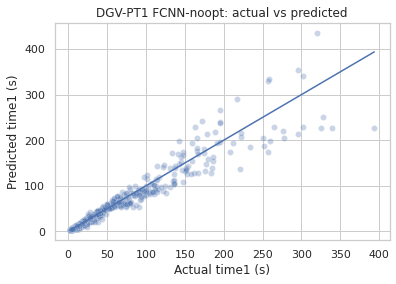

In [10]:
plt.title("DGV-PT1 FCNN-noopt: actual vs predicted")
plt.plot([test_res_noopt.target.min(), test_res_noopt.target.max()], [test_res_noopt.target.min(), test_res_noopt.target.max()])
sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.prediction, alpha=0.3)
plt.xlabel("Actual time1 (s)")
plt.ylabel("Predicted time1 (s)")
plt.savefig("tex/images/dgv-pt1/fcnn-noopt-correlazione-osservazione-previsione.pdf")
plt.show()

Anche il grafico dei residui rispetto al valore predetto presenta pattern meno evidenti. Tuttavia, l'errore aumenta all'aumentare del tempo.

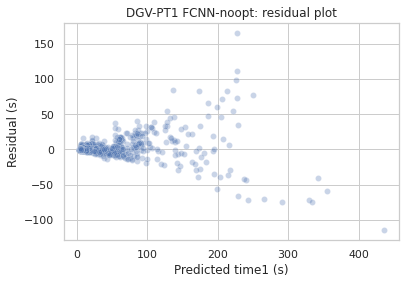

In [11]:
plt.title("DGV-PT1 FCNN-noopt: residual plot")
sns.scatterplot(data=test_res_noopt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time1 (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgv-pt1/fcnn-noopt-grafico-residui.pdf")
plt.show()

## DGV-PT1 con HP tuning
Il modello è stato sottoposto a hyperparameter tuning con Bayesian Optimization. Come funzione obiettivo da minimizzare è stato considerato unicamente RMSE, in quanto si è interessati a minimizzare l'errore per le esecuzioni più lunghe e a non avere outlier. Per ogni tentativo, è stato effettuato il 10-fold cross validation ed è stato preso il minimo valore di RMSE del cross-validation set.

In [12]:
with open("data/hpopt/DGV_PT1.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial

In [13]:
cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
config = best["result"]["config"]

In [14]:
print("Best loss", best["result"]["loss"])

Best loss 4.309012504542603


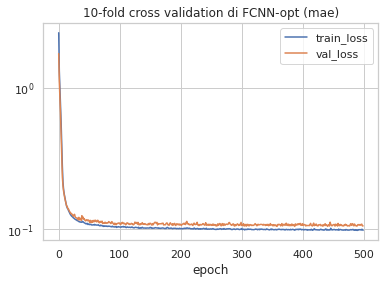

In [15]:
cv_res.groupby("epoch")[["train_loss", "val_loss"]].mean().plot(grid=True, logy=True)
plt.title(f"10-fold cross validation di FCNN-opt ({config['loss']})")
plt.show()

Epoch del minimo della funzione obiettivo, sarà usata successivamente per riaddestrare il modello.

In [16]:
best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
print("Best epoch", best_epoch)

Best epoch 441


Il modello ottimizzato ha due hidden layer di dimensione maggiore rispetto al modello non ottimizzato e usa MAE come loss function.

In [17]:
print(yaml.dump(config))

batch: 128
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 48
  - dropout: 0.0
    size: 43
optimizer:
  lr: 0.001274530964962364
  name: adam
  weight_decay: 0.08709111541194206



Il modello viene riaddestrato usando tutto il training set, fino all'epoch che ha dato il miglior risultato durante l'HP tuning.

In [18]:
data = CosmoData(train_df, None, test_df, config["batch"])
model = CosmoPredictor(data.input_size, config)
train_res_opt = model.fit(data, best_epoch)
test_res_opt = model.test(data)

<AxesSubplot:>

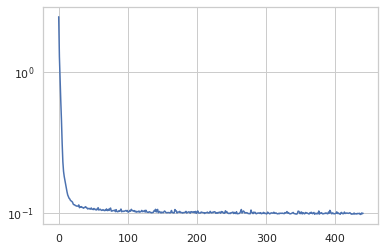

In [19]:
train_res_opt.train_loss.plot(grid=True, logy=True)

Si nota un miglioramento sia nell'errore assoluto che relativo rispetto al modello non ottimizzato (tranne che per l'errore relativo massimo, che rimane uguale).

In [20]:
test_res_opt["abs_err"] = (test_res_opt.target - test_res_opt.prediction).abs()
test_res_opt["rel_err"] = test_res_opt.abs_err / test_res_opt.target
test_res_opt["residual"] = test_res_opt.target - test_res_opt.prediction
test_res_opt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,2.287272,0.102672
std,3.699217,0.102281
min,0.000168,0.000039
25%,0.487539,0.027051
50%,0.968773,0.069917
75%,2.112652,0.142790
max,36.868622,0.629158


Il RMSE è migliore rispetto al modello non ottimizzato e si discosta di 0.04 secondi (in più) rispetto al RMSE del cross-validation set.

In [21]:
print("RMSE:", np.sqrt((test_res_opt.abs_err ** 2).mean()))

RMSE: 4.347658679723331


Il confronto tra osservato e previsto mostra un miglioramento notevole.

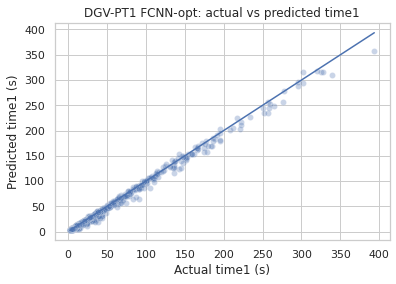

In [22]:
plt.title("DGV-PT1 FCNN-opt: actual vs predicted time1")
plt.plot([test_res_opt.target.min(), test_res_opt.target.max()], [test_res_opt.target.min(), test_res_opt.target.max()])
sns.scatterplot(x=test_res_opt.target, y=test_res_opt.prediction, alpha=0.3)
plt.xlabel("Actual time1 (s)")
plt.ylabel("Predicted time1 (s)")
plt.savefig("tex/images/dgv-pt1/fcnn-opt-correlazione-osservazione-previsione.pdf")
plt.show()

Nel grafico dei residui si nota una lieve eteroschedasticità.

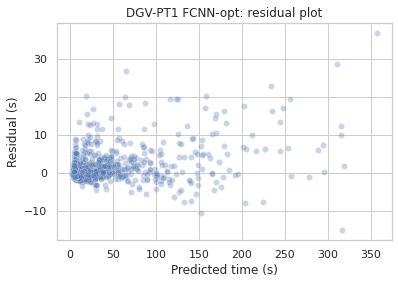

In [23]:
plt.title("DGV-PT1 FCNN-opt: residual plot")
sns.scatterplot(data=test_res_opt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgv-pt1/fcnn-opt-grafico-residui.pdf")
plt.show()

Di seguito, i valori di MAE, RMSE, MAPE dei 4 modelli, dove possiamo vedere come i due FCNN sono sensibilmente migliore degli altri 3 (in particolar modo quella ottimizzata).

In [24]:
for name, df in zip(("LR", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_noopt, test_res_opt)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE LR: 12.482856466593871
MAE FCNN no-opt: 6.110857027053833
MAE FCNN opt: 2.287271902322769


In [25]:
for name, df in zip(("LR", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_noopt, test_res_opt)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE LR: 29.01896514078914
RMSE FCNN no-opt: 15.086426685600335
RMSE FCNN opt: 4.347658679723331


In [26]:
for name, df in zip(("LR", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_noopt, test_res_opt)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE LR: 36.69503944715994
MAPE FCNN no-opt: 15.414961827783463
MAPE FCNN opt: 10.267162331904567


Qui sotto, sono confrontati i grafici di correlazione tra errore assoluto e tempo osservato dei tre modelli. Si può notare il netto miglioramento per i task con tempo maggiore.

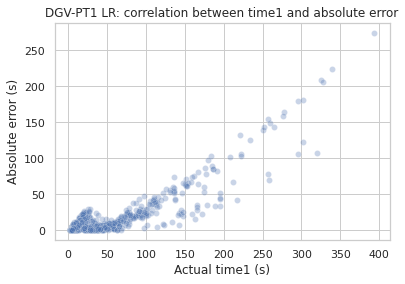

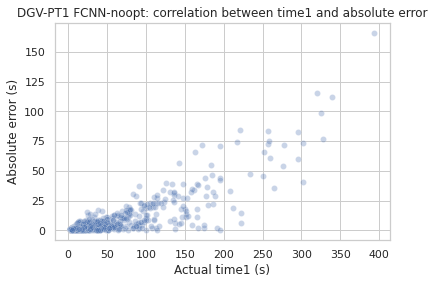

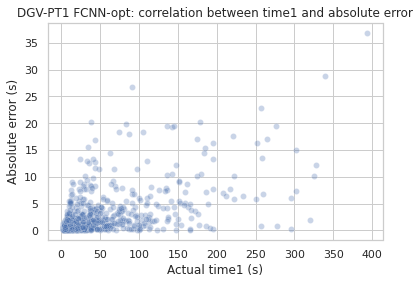

In [27]:
sns.scatterplot(x=test_res_lr.time1, y=test_res_lr.abs_err, alpha=0.3)
plt.title("DGV-PT1 LR: correlation between time1 and absolute error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgv-pt1/lr-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.abs_err, alpha=0.3)
plt.title("DGV-PT1 FCNN-noopt: correlation between time1 and absolute error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgv-pt1/fcnn-noopt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_opt.target, y=test_res_opt.abs_err, alpha=0.3)
plt.title("DGV-PT1 FCNN-opt: correlation between time1 and absolute error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgv-pt1/fcnn-opt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

Qui sotto vediamo invece la correlazione con l'errore relativo: si nota come nel caso di LR l'errore sia alto nel caso di tempi brevi e poi torni a salire per i tempi più lunghi. Negli altri due casi, invece, si hanno risultati peggiori nel caso dei tempi brevi (ma significativamente migliori rispetto a LR) e nel caso ottimizzato non sia più presente un rapporto lineare tra errore relativo e tempo di esecuzione. L'errore peggiore per valori osservati più piccoli è accettabile, in quanto si è data maggior attenzione a minimizzare l'errore assoluto e gli outlier.

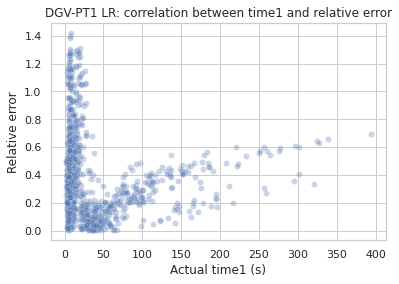

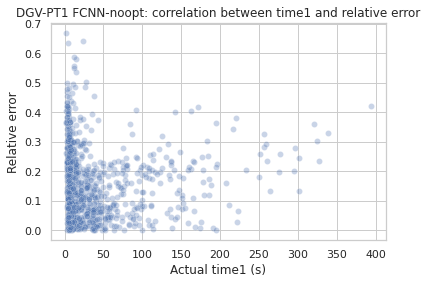

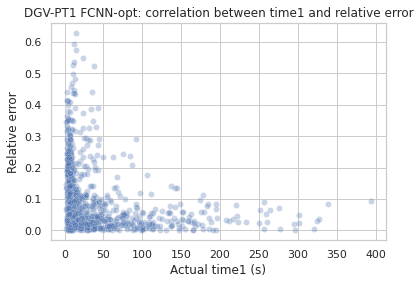

In [28]:
sns.scatterplot(x=test_res_lr.time1, y=test_res_lr.rel_err, alpha=0.3)
plt.title("DGV-PT1 LR: correlation between time1 and relative error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgv-pt1/lr-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.rel_err, alpha=0.3)
plt.title("DGV-PT1 FCNN-noopt: correlation between time1 and relative error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgv-pt1/fcnn-noopt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_opt.target, y=test_res_opt.rel_err, alpha=0.3)
plt.title("DGV-PT1 FCNN-opt: correlation between time1 and relative error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgv-pt1/fcnn-opt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

Di seguito, possiamo vedere le funzioni cumulative dell'errore assoluto e relativo nei tre modelli studiati. Come si poteva già dedurre dalle precedenti osservazioni, i modelli FCNN sono migliori della LR (in particolar modo per quanto riguarda l'errore relativo). Inoltre, l'FCNN ottimizzato ha una curva più ripida rispetto a quello non ottimizzato: questo comporta che un numero maggiore di previsioni ha al massimo un certo errore - e quindi gli errori peggiori riguardano una percentuale minore del test set. FCNN ottimizzato, inoltre, ha un errore assoluto massimo di un ordine di grandezza più piccolo rispetto al modello non ottimizzato.

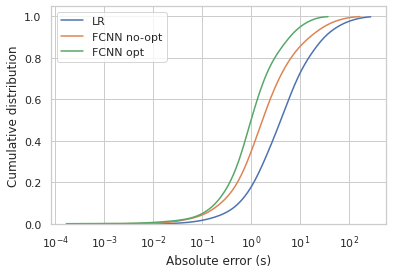

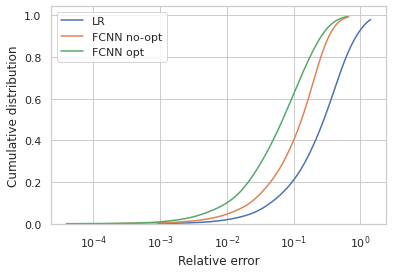

In [29]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgv-pt1/cdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgv-pt1/cdf-errore-relativo.pdf")
plt.legend()
plt.show()

Nel caso delle funzioni di distribuzione dell'errore assoluto e relativo, notiamo come tutti i modelli abbiano un andamento unimodale.

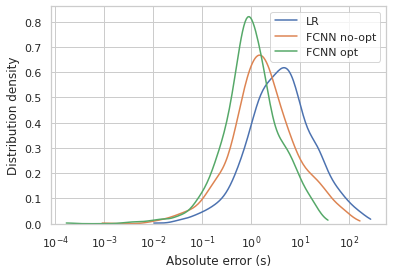

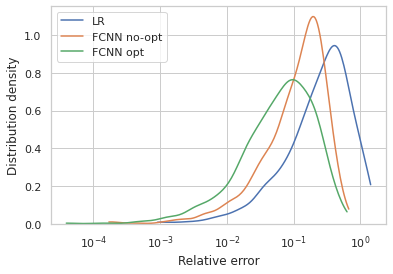

In [30]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgv-pt1/pdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.legend()
plt.savefig("tex/images/dgv-pt1/pdf-errore-relativo.pdf")
plt.show()

Qui sotto, si riportano i grafici dei tre modelli che mostrano il rapporto tra osservato e previsto, in modo da poterli confrontare più facilmente.

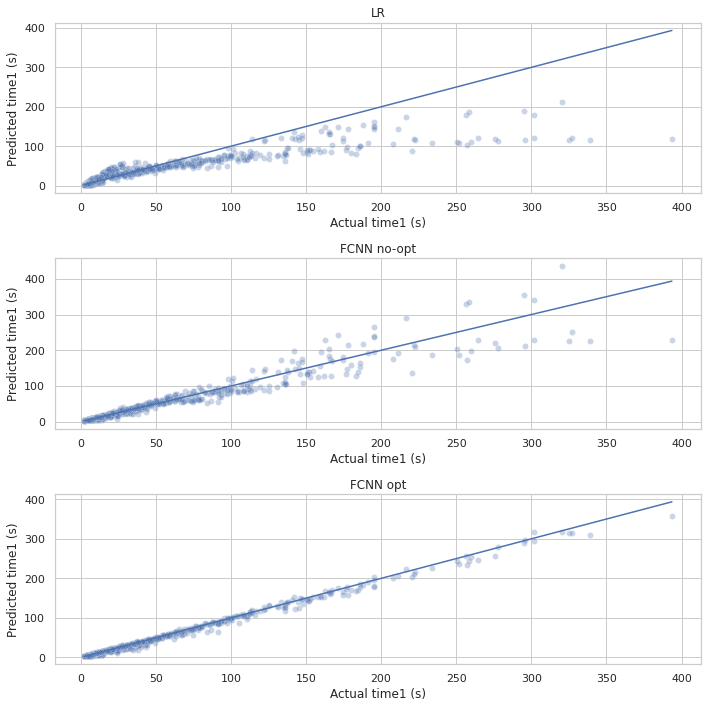

In [31]:
figure, axs = plt.subplots(3, figsize=(10, 10))

for ax, name, df in zip(axs, ("LR", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_noopt, test_res_opt)):
    ax.set_title(f"{name}")
    ax.set_xlabel("Actual time1 (s)")
    ax.set_ylabel("Predicted time1 (s)")
    ax.plot([df.target.min(), df.target.max()], [df.target.min(), df.target.max()])
    sns.scatterplot(x=df.target, y=df.prediction, alpha=0.3, ax=ax)
    
figure.tight_layout()
plt.show()

## Conclusioni
Il modello ottimizzato ha prestazioni molto migliori rispetto non solo al modello LR ma anche rispetto all'FCNN non ottimizzato. Il 99% ha un errore assoluto minore di 20 secondi e un errore relativo minore di ~45%: le prestazioni sono soddisfacenti, considerando tra l'altro che questo modello prevede il tempo di esecuzione solo per la prima ora di previsione e quindi influenza in minima parte la previsione complessiva.

In [32]:
test_res_opt[["abs_err", "rel_err"]].quantile([0.9, 0.95, 0.98, 0.99], interpolation="higher")

,abs_err,rel_err
0.90,5.812805,0.237226
0.95,9.147537,0.313307
0.98,16.218048,0.410686
0.99,19.416199,0.470404


Nel dataset non sono presenti anomalie, quindi ne viene presa una dal training set di DGV. L'anomalia verrebbe riconosciuta grazie a due indicatori:
* Il primo indizio è fornito dall'errore assoluto (46.2 secondi), che è oltre il 98° percentile
* Il secondo indizio è fornito dall'errore relativo (40%), che per job con tempo di esecuzione maggiore di 100 secondi dovrebbe essere minore del 20%.

In [33]:
anomaly_df = pd.read_csv(io.StringIO((
    "x_length,y_length,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time1\n"
    "10000,10000,20,14,32,0,1.8235294117647056,115.24"
)))

data = CosmoData(train_df, None, anomaly_df, "all")
anomaly_res_opt = model.test(data)

In [34]:
anomaly_res_opt

,target,prediction
0,115.240005,69.053162


In [35]:
print("Errore assoluto:", (anomaly_res_opt["target"] - anomaly_res_opt["prediction"]).abs())
print("Errore relativo:", ((anomaly_res_opt["target"] - anomaly_res_opt["prediction"])/anomaly_res_opt["target"]).abs())

Errore assoluto: 0    46.186844
dtype: float64
Errore relativo: 0    0.400788
dtype: float64


In [36]:
pd.concat([test_df, test_res_opt], axis=1).query("x_length == 46000 and y_length == 14400 and grid_step == 20 and n_nodes == 25 and n_cores == 36")

,x_length,y_length,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time1,target,prediction,abs_err,rel_err,residual
989,46000,14400,20,25,36,0,2.25,295.11,295.110077,288.983032,6.127045,0.020762,6.127045
